# Surrender Index

## Functions

In [129]:
import pandas as pd
import numpy as np

In [130]:
import matplotlib.pyplot as plt

In [131]:
def scoreDiff(row):
    if row['recTeam'] == row['awayTeam']:
        return row['homeScore'] - row['awayScore']
    else:
        return row['awayScore'] - row['homeScore']

In [132]:
def secSinceHalf(row):
    return 1800 - int(row['totTime'])

In [133]:
def fieldPosScore(row):
    if row['dist2goal'] >= 60:
        return 1.0
    elif row['dist2goal'] >= 50:
        return 1.1 ** (40 - row['dist2goal'])
    else:
        return 1.1**10 * 1.2**(50 - row['dist2goal'])

In [134]:
def distScore(row):
    if int(row['distance']) >= 10:
        return 0.2
    elif 7 <= row['distance'] <= 9:
        return 0.4
    elif 4 <= row['distance'] <= 6:
        return 0.6
    elif 2 <= row['distance'] <= 3:
        return 0.8
    else:
        return 1.0

In [135]:
def scoreDiffMult(pointdiff):
    if pointdiff > 0:
        return 1
    elif pointdiff == 0:
        return 2
    elif pointdiff < -8:
        return 3
    else:
        return 4

In [136]:
def timeMult(row):
    sec = secSinceHalf(row)
    PD = scoreDiff(row)
    
    if PD <= 0 and sec >= 0:
        return ((sec * 0.001)**3) + 1.
    else:
        return 1.

In [137]:
def surrenderIndex(row):
    pd = scoreDiff(row)
#     print(fieldPosScore(row),distScore(row),scoreDiffMult(pd),timeMult(row))
    return fieldPosScore(row) * distScore(row) * scoreDiffMult(pd) * timeMult(row)

## Punts

In [138]:
allData = pd.read_csv('all_post19.csv')

In [139]:
puntDF = allData[allData['play'].str.contains('Punt ')]

In [140]:
puntDF = puntDF.rename(columns = {'teamPoss':'recTeam'})

In [141]:
def fixAZBug(row): #Only for Punts!
    if row['recTeam'] == 'AZ':
        row['dist2goal'] = 100 - row['dist2goal']
        if row['homeTeam'] == 'AZ':
            row['side'] = row['awayTeam']
        else:
            row['side'] = row['homeTeam']
    return row

In [142]:
puntDF = puntDF.apply(lambda row : fixAZBug(row),axis=1)

In [143]:
puntDF['surrenderIndex'] = puntDF.apply(lambda row : surrenderIndex(row),axis=1)

In [144]:
puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','recTeam','down','distance','dist2goal','surrenderIndex','play']]

In [145]:
puntDF = puntDF.sort_values('surrenderIndex',ascending=False)

In [146]:
from scipy.stats import percentileofscore as perc

In [147]:
NFL = np.load("2009-2018_surrender_indices.npy")

In [148]:
np.percentile(NFL,90)

7.469978285088006

In [149]:
max(NFL)

659.6974951326805

In [150]:
puntDF['NFLpercentiles'] = puntDF.apply(lambda row : perc(NFL,row['surrenderIndex']),axis=1)

In [151]:
puntDF['percentiles'] = puntDF.apply(lambda row : perc(puntDF['surrenderIndex'],row['surrenderIndex']),axis=1)

In [152]:
min(NFL)

0.2

In [153]:
min(puntDF['surrenderIndex'])

0.03270159816531156

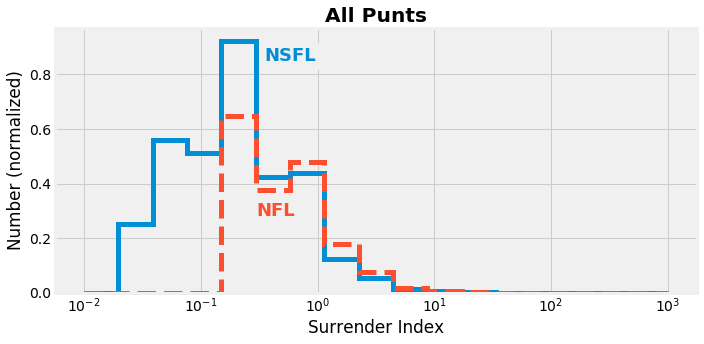

In [154]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('All Punts',weight='bold')
plt.xlabel('Surrender Index')
plt.ylabel('Number (normalized)')
bins = np.logspace(-2,3,18)
plt.hist(puntDF['surrenderIndex'],bins=bins,histtype='step',color='C0',density=True,lw=5,label='NSFL')
plt.hist(NFL,bins=bins,color='C1',histtype='step',density=True,lw=5,ls='--',label='NFL')
plt.xscale('log')
plt.text(x=0.35,y=0.85,s='NSFL',c='C0',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.text(x=0.3,y=0.28,s='NFL',c='C1',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.tight_layout()
plt.savefig('images/surrenderindexes.png')
plt.show()

In [155]:
def touchback(row):
    if 'Touchback' in row['play']:
        return "Touchback"
    elif 'No return' in row['play']:
        return "No return"
    else:
        return "Returned"

In [156]:
puntDF['result'] = puntDF.apply(lambda row : touchback(row),axis = 1)

In [157]:
puntDF['scoreDiff'] = puntDF.apply(lambda row : scoreDiff(row),axis = 1)

In [158]:
puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','recTeam','down','distance','dist2goal','surrenderIndex','percentiles','NFLpercentiles','play','result']]

In [159]:
puntDF[(puntDF['gameID'] == 2575) & (puntDF['recTeam'] == 'OCO')].sort_values('surrenderIndex',ascending=False)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,surrenderIndex,percentiles,NFLpercentiles,play,result
156574,10,2575,2,4:08,COL,7,0,OCO,OCO,4.0,14.0,36.0,6.660308,86.292859,88.870306,"Punt by McCormick, M. of 36 yards. Touchback.",Touchback
156529,10,2575,1,6:06,COL,0,0,OCO,OCO,4.0,10.0,45.0,2.581624,74.452134,71.992593,"Punt by McCormick, M. of 45 yards. Touchback.",Touchback
156597,10,2575,2,0:22,COL,7,3,OCO,OCO,4.0,3.0,63.0,0.800000,46.820279,35.567236,"Punt by McCormick, M. of 32 yards.",Returned
156582,10,2575,2,1:54,COL,7,0,OCO,OCO,4.0,6.0,93.0,0.600000,34.104016,22.910445,"Punt by McCormick, M. of 37 yards.",Returned
156511,10,2575,1,14:12,COL,0,0,OCO,OCO,4.0,14.0,61.0,0.400000,25.521653,14.231673,"Punt by McCormick, M. of 59 yards. No return.",No return
156564,10,2575,2,8:22,COL,7,0,OCO,OCO,4.0,12.0,82.0,0.200000,12.857817,4.254768,"Punt by McCormick, M. of 39 yards. No return.",No return
156663,10,2575,4,11:34,COL,24,3,OCO,OCO,4.0,1.0,58.0,0.179859,7.809059,0.000000,"Punt by McCormick, M. of 57 yards. Touchback.",Touchback
156690,10,2575,4,2:53,COL,26,3,OCO,OCO,4.0,4.0,54.0,0.157999,6.676628,0.000000,"Punt by McCormick, M. of 32 yards.",Returned
156681,10,2575,4,5:29,COL,24,3,OCO,OCO,4.0,16.0,51.0,0.070099,2.267485,0.000000,"Punt by McCormick, M. of 50 yards. No return.",No return


In [160]:
puntArr = []
for i in range(30,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntArr.append(i4df['result'].value_counts(normalize=True))

In [161]:
puntArr[3]['Touchback']

0.9902912621359223

In [162]:
tbList = []
nrList = []
rList = []
for f in puntArr:
    try:
        tbList.append(f['Touchback'])
    except KeyError:
        tbList.append(0.)
    try:
        nrList.append(f['No return'])
    except KeyError:
        nrList.append(0.)
    try:
        rList.append(f['Returned'])
    except KeyError:
        rList.append(0.)

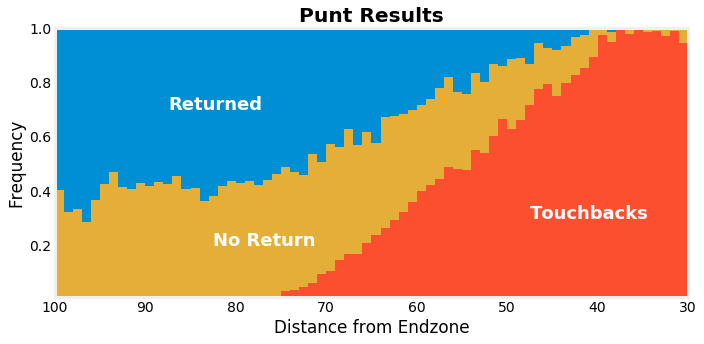

In [163]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,rList,bottom=[tbList[i]+nrList[i] for i in range(len(yardRange))],width=1,label='Returned',color='C0',align='edge')
plt.bar(yardRange,nrList,bottom=tbList,width=1,label='No Return',color='C2',align='edge')
plt.bar(yardRange,tbList,width=1,label='Touchback',color='C1',align='edge')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 47.5, y = 0.3, s = 'Touchbacks', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 82.5, y = 0.2, s = 'No Return', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 87.5, y = 0.7, s = 'Returned', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100,30)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results.png')
plt.show()

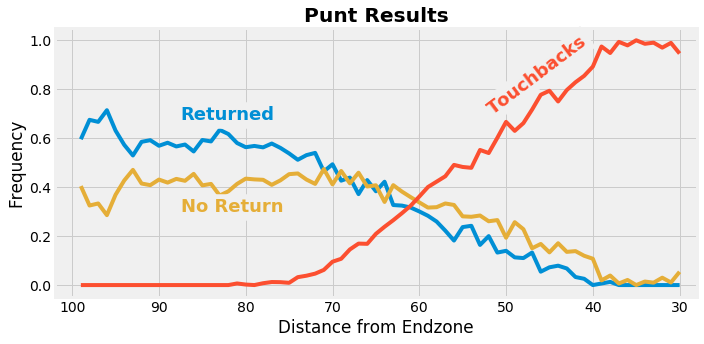

In [164]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,rList,label='Returned',color='C0')
plt.plot(yardRange,nrList,label='No Return',color='C2')
plt.plot(yardRange,tbList,label='Touchback',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 52.5, y = 0.7, s = 'Touchbacks', color = 'C1', weight = 'bold', size = 18, rotation = 37, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.3, s = 'No Return', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.675, s = 'Returned', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results_line.png')
plt.show()

In [165]:
puntDF[puntDF['result'] == 'Touchback'].sort_values('dist2goal',ascending=False).head(10)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,surrenderIndex,percentiles,NFLpercentiles,play,result
53726,4,757,3,13:14,ARI,7,13,LV,LV,4.0,6.0,81.0,2.402858,73.288246,70.624776,"Punt by Ronaldo, C. of 80 yards. Touchback.",Touchback
282114,18,4563,2,3:57,CHI,13,17,YKW,YKW,4.0,2.0,81.0,3.200000,77.755059,76.824752,"Punt by Fulture, K. of 80 yards. Touchback.",Touchback
80153,6,1583,4,11:24,PHI,17,27,BAL,PHI,4.0,10.0,80.0,0.200000,12.857817,4.254768,"Punt by Turkleton, T. of 80 yards. Touchback.",Touchback
45478,4,719,3,1:09,ARI,19,10,LV,LV,4.0,8.0,78.0,0.400000,25.521653,14.231673,"Punt by Ronaldo, C. of 78 yards. Touchback.",Touchback
44412,4,714,4,13:16,ARI,3,7,PHI,PHI,4.0,8.0,78.0,3.219277,78.562441,77.800342,"Punt by Ronaldo, C. of 78 yards. Touchback.",Touchback
89072,6,1624,2,1:27,SJS,6,0,NO,NO,4.0,3.0,78.0,0.800000,46.820279,35.567236,"Punt by Blewitt, I. of 77 yards. Touchback.",Touchback
127198,9,2310,3,7:06,COL,10,24,YKW,YKW,4.0,13.0,77.0,0.663898,40.620740,29.255764,"Punt by McCormick, M. of 76 yards. Touchback.",Touchback
35488,3,300,2,13:41,ARI,14,0,COL,COL,4.0,1.0,77.0,1.000000,54.652931,44.600406,"Punt by Ronaldo, C. of 77 yards. Touchback.",Touchback
145994,10,2526,2,6:40,BAL,17,7,COL,BAL,4.0,17.0,77.0,0.600000,37.548495,26.466372,"Punt by McCormick, M. of 77 yards. Touchback.",Touchback
87165,6,1615,3,1:25,SJS,6,33,PHI,PHI,4.0,16.0,77.0,0.924806,53.219042,42.416278,"Punt by Blewitt, I. of 77 yards. Touchback.",Touchback


In [166]:
puntDF.sort_values('surrenderIndex',ascending=False).head(6)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,surrenderIndex,percentiles,NFLpercentiles,play,result
82122,6,1592,5,12:29,YKW,27,27,NO,YKW,4.0,2.0,32.0,930.991208,100.000000,100.0,"Punt by Lombardi, J. of 32 yards. Touchback.",Touchback
167355,11,2698,4,4:24,YKW,21,17,PHI,YKW,4.0,1.0,35.0,739.114908,99.994757,100.0,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Touchback
2730,1,18,4,2:03,BAL,20,23,COL,COL,4.0,3.0,35.0,730.985378,99.989515,100.0,"Punt by Harris, S. of 35 yards. Touchback.",Touchback
38635,3,314,4,3:16,PHI,14,17,YKW,YKW,4.0,5.0,33.0,708.052379,99.984272,100.0,"Punt by Harris, S. of 33 yards. Touchback.",Touchback
101482,7,1754,4,8:30,YKW,23,20,SJS,YKW,4.0,3.0,32.0,695.333384,99.979029,100.0,"Punt by Blewitt, I. of 32 yards. Touchback.",Touchback
101920,7,1756,4,4:04,COL,3,38,NO,NO,4.0,1.0,34.0,685.834609,99.973786,100.0,"Punt by McCormick, M. of 34 yards. Touchback.",Touchback


In [167]:
puntDF.to_csv('allpunts.csv')

In [168]:
puntDF.to_json('allpunts.json')

## Fourth Downs

In [169]:
fourthDF = allData[allData['down'] == 4.0]

In [170]:
def playType(play):
#     print(play)
    if 'Punt' in play:
        ptype = 'Punt'
    elif 'FG' in play:
        ptype = 'FG'
    elif 'Timeout' in play:
        ptype = 'Timeout'
    else:
        ptype = 'Try'
    return ptype

In [171]:
fourthDF = fourthDF.rename(columns = {'teamPoss':'recTeam'})

In [172]:
fourthDF['playType'] = fourthDF.apply(lambda row : playType(row['play']),axis=1)

In [173]:
def fixAZBug2(row):
    try:
        if row['recTeam'] == 'AZ' and row['playType'] == 'Punt':
            row['dist2goal'] = 100 - row['dist2goal']
            if row['homeTeam'] == 'AZ':
                row['side'] = row['awayTeam']
            else:
                row['side'] = row['homeTeam']
        return row
    except KeyError:
        return row

In [174]:
fourthDF = fourthDF.apply(lambda row : fixAZBug2(row),axis=1)

In [175]:
fourthDF['scoreDiff'] = fourthDF.apply(lambda row : scoreDiff(row),axis=1)

In [176]:
fourthDF = fourthDF[~fourthDF['playType'].str.contains('Timeout')]

In [177]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Penalty')]

In [178]:
fourthTryDF = fourthDF[fourthDF['playType'] == 'Try']

In [179]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Turnover')]

In [180]:
fourthDF['playType'].value_counts(normalize=True)

Punt    0.720862
FG      0.188927
Try     0.090212
Name: playType, dtype: float64

In [181]:
fourthArr = []
for i in range(1,100):
    i4df = fourthDF[fourthDF['dist2goal'] == i]
    fourthArr.append(i4df['playType'].value_counts(normalize=True))

In [182]:
fourthArr[0]['FG']

0.9310344827586207

In [183]:
FGlist = []
PuntList = []
TryList = []
TOList = []
for f in fourthArr:
    try:
        FGlist.append(f['FG'])
    except KeyError:
        FGlist.append(0.)
    try:
        PuntList.append(f['Punt'])
    except KeyError:
        PuntList.append(0.)
    try:
        TryList.append(f['Try'])
    except KeyError:
        TryList.append(0.)
    try:
        TOList.append(f['Timeout'])
    except KeyError:
        TOList.append(0.)

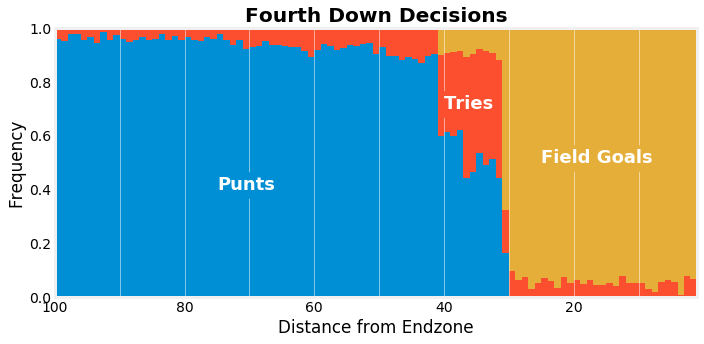

In [184]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,FGlist,bottom=[TryList[i]+PuntList[i] for i in range(99)],width=1,label='Field Goals',color='C2',align='edge')
plt.bar(yardRange,TryList,bottom=PuntList,width=1,label='Tries',color='C1',align='edge')
plt.bar(yardRange,PuntList,width=1,label='Punts',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(100,1)
plt.ylim(0,1)
plt.text(x = 40, y = 0.7, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 25, y = 0.5, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 75, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
# plt.legend(loc=5)
plt.tight_layout()
plt.savefig('images/4thdownbar.png')
plt.show()

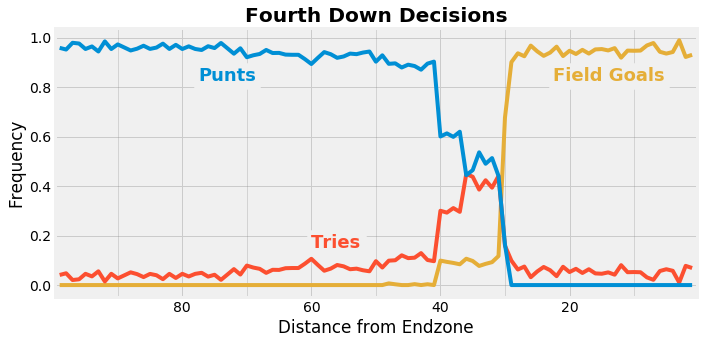

In [185]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
for i in [10,30,50,70,90]:
    plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
plt.xlim(99.75,0.25)
# plt.ylim(0,1)
# plt.legend(loc=5)
plt.text(x = 60, y = 0.15, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 22.5, y = 0.825, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 77.5, y = 0.825, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdownline.png')
plt.show()

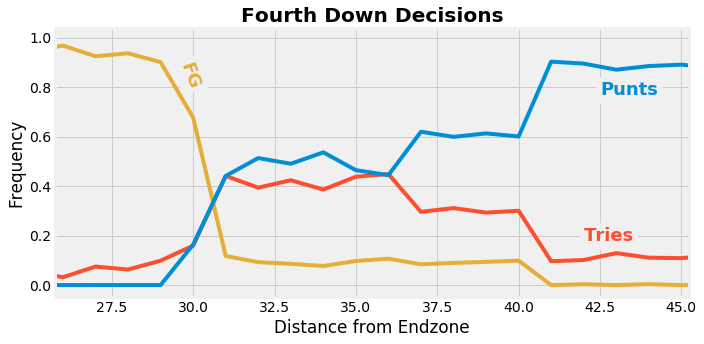

In [186]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
# plt.plot(yardRange,TOList,label='Timeouts',c='C3')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
# for i in [10,30,50,70,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.xlim(25.75,45.25)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 42, y = 0.18, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 29.5, y = 0.8, s = 'FG', color = 'C2', weight = 'bold', rotation = -70, size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 42.5, y = 0.77, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_dead.png')
plt.show()

In [187]:
deadZoneDF = fourthDF[(fourthDF['dist2goal'] <= 40) & (30 <= fourthDF['dist2goal'])]

In [188]:
len(deadZoneDF)

2635

In [189]:
deadZoneArr = []
deadZoneArrn = []
for i in range(1,51):
    i4df = deadZoneDF[deadZoneDF['distance'] == i]
    deadZoneArr.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrn.append(i4df['playType'].value_counts(normalize=False))

In [190]:
dFGlist = []
dPuntList = []
dTryList = []
dTOList = []
noneList = []

for f in deadZoneArr:
    i = 0
    try:
        dFGlist.append(f['FG'])
    except KeyError:
        dFGlist.append(0.)
        i += 1
    try:
        dPuntList.append(f['Punt'])
    except KeyError:
        dPuntList.append(0.)
        i+=1
    try:
        dTryList.append(f['Try'])
    except KeyError:
        dTryList.append(0.)

In [191]:
dFGlistn = []
dPuntListn = []
dTryListn = []
dTOListn = []
noneListn = []

for f in deadZoneArrn:
    i = 0
    try:
        dFGlistn.append(f['FG'])
    except KeyError:
        dFGlistn.append(0.)
        i += 1
    try:
        dPuntListn.append(f['Punt'])
    except KeyError:
        dPuntListn.append(0.)
        i+=1
    try:
        dTryListn.append(f['Try'])
    except KeyError:
        dTryListn.append(0.)

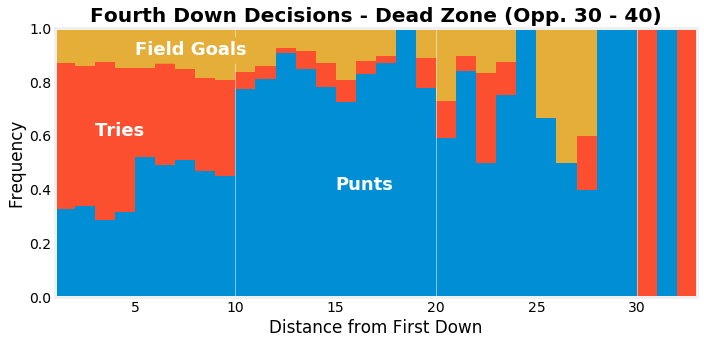

In [192]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntList,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryList,bottom=dPuntList,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlist,bottom=[dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 3, y = 0.6, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.9, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 15, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist.png')
plt.show()

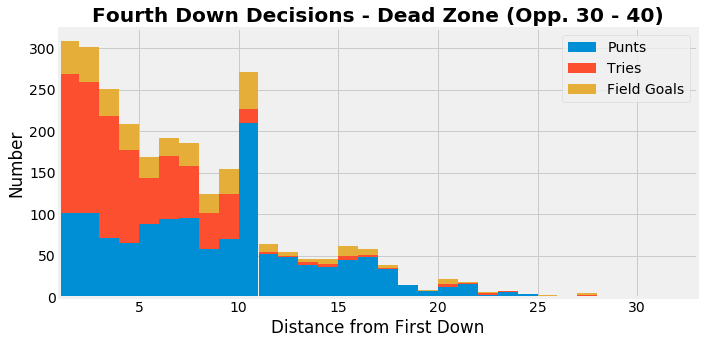

In [193]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListn,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListn,bottom=dPuntListn,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistn,bottom=[dTryListn[i]+dPuntListn[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_total.png')
plt.show()

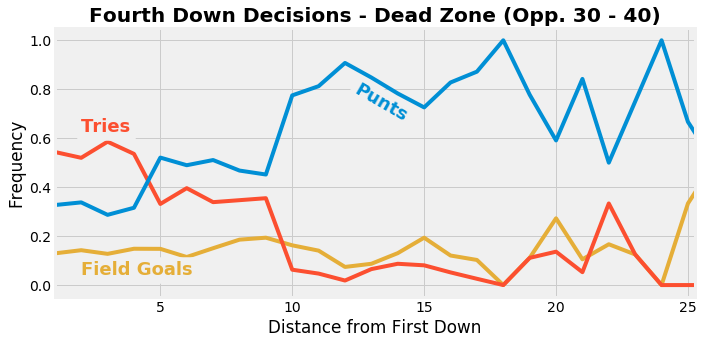

In [194]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.plot(yardRange,dFGlist,label='Field Goals',c='C2')
plt.plot(yardRange,dTryList,label='Tries',c='C1')
plt.plot(yardRange,dPuntList,label='Punts',c='C0')
# plt.plot(yardRange,dTOList,label='Timeouts')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,25.25)
# plt.ylim(0,1.01)
# plt.legend(loc=0)
plt.text(x = 2, y = 0.625, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 2, y = 0.04, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 12.25, y = 0.67, s = 'Punts', color = 'C0', weight = 'bold', rotation = -30, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_line.png')
plt.show()

In [195]:
deadZoneDF4q = deadZoneDF[deadZoneDF['Q'] >= 4]
len(deadZoneDF4q)

785

In [196]:
deadZoneArrPD = []
deadZoneArrPDn = []
for i in range(0,16):
    i4df = deadZoneDF4q[deadZoneDF4q['scoreDiff'] == i]
    deadZoneArrPD.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrPDn.append(i4df['playType'].value_counts(normalize=False))

In [197]:
dFGlistpd = []
dPuntListpd = []
dTryListpd = []
dTOListpd = []
noneListpd = []

for f in deadZoneArrPD:
    i = 0
    try:
        dFGlistpd.append(f['FG'])
    except KeyError:
        dFGlistpd.append(0.)
        i += 1
    try:
        dPuntListpd.append(f['Punt'])
    except KeyError:
        dPuntListpd.append(0.)
        i+=1
    try:
        dTryListpd.append(f['Try'])
    except KeyError:
        dTryListpd.append(0.)

In [198]:
dFGlistnpd = []
dPuntListnpd = []
dTryListnpd = []
dTOListnpd = []
noneListnpd = []

for f in deadZoneArrPDn:
    i = 0
    try:
        dFGlistnpd.append(f['FG'])
    except KeyError:
        dFGlistnpd.append(0.)
        i += 1
    try:
        dPuntListnpd.append(f['Punt'])
    except KeyError:
        dPuntListnpd.append(0.)
        i+=1
    try:
        dTryListnpd.append(f['Try'])
    except KeyError:
        dTryListnpd.append(0.)

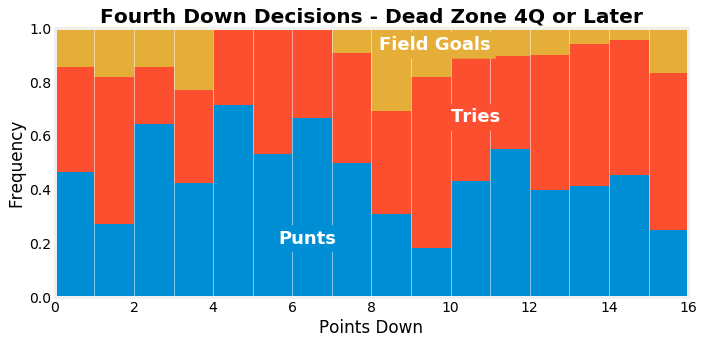

In [199]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone 4Q or Later',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntListpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListpd,bottom=dPuntListpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistpd,bottom=[dTryListpd[i]+dPuntListpd[i] for i in range(len(dFGlistpd))],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in range(16):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 10, y = 0.65, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 8.2, y = 0.92, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 5.65, y = 0.2, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadPD.png')
plt.show()

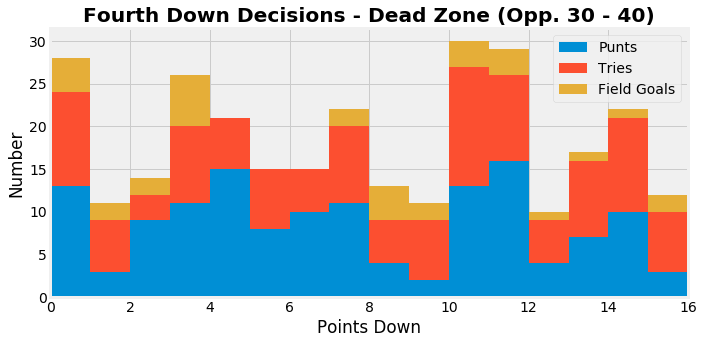

In [200]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListnpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListnpd,bottom=dPuntListnpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistnpd,bottom=[dTryListnpd[i]+dPuntListnpd[i] for i in range(16)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadPD_total.png')
plt.show()

## Field Goals

In [201]:
FGDF = allData[(allData['play'].str.contains('FG'))]

In [202]:
def fgDist(play):
    return int(play[:2])

In [203]:
FGDF['FGdist'] = FGDF.apply(lambda row : fgDist(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [204]:
def fgRes(play):
    if 'BLOCKED' in play:
        return 'Block'
    elif 'NO good' in play:
        return 'Miss'
    else:
        return 'Good'

In [205]:
FGDF['FGresult'] = FGDF.apply(lambda row : fgRes(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [206]:
FGDF['FGresult'].value_counts(normalize=True)

Good     0.877152
Miss     0.120855
Block    0.001993
Name: FGresult, dtype: float64

In [207]:
fgDistArr = []
fgDistArrn = []
fgRange = np.arange(20,100,5)
for i in fgRange:
    i4df = FGDF[(i-5 < FGDF['FGdist']) & (FGDF['FGdist'] <= i)]
    fgDistArr.append(i4df['FGresult'].value_counts(normalize=True))
    fgDistArrn.append(i4df['FGresult'].value_counts(normalize=False))

In [208]:
goodList = []
missList = []
blockList = []
for f in fgDistArr:
    try:
        goodList.append(f['Good'])
    except KeyError:
        goodList.append(0.)
    try:
        missList.append(f['Miss'])
    except KeyError:
        missList.append(0.)
    try:
        blockList.append(f['Block'])
    except KeyError:
        blockList.append(0.)

In [209]:
goodListn = []
missListn = []
blockListn = []
for f in fgDistArrn:
    try:
        goodListn.append(f['Good'])
    except KeyError:
        goodListn.append(0.)
    try:
        missListn.append(f['Miss'])
    except KeyError:
        missListn.append(0.)
    try:
        blockListn.append(f['Block'])
    except KeyError:
        blockListn.append(0.)

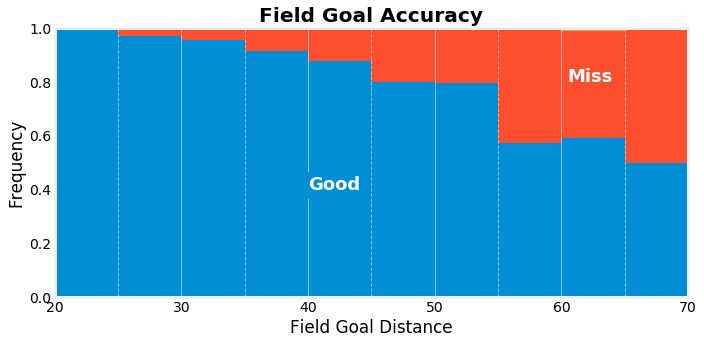

In [210]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Frequency')
plt.bar(fgRange,blockList,bottom=[goodList[i]+missList[i] for i in range(len(goodList))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missList,bottom=goodList,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodList,width=5,label='Good',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(20,70)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 60.5, y = 0.8, s = 'Miss', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.4, s = 'Good', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/fgResults.png')
plt.show()

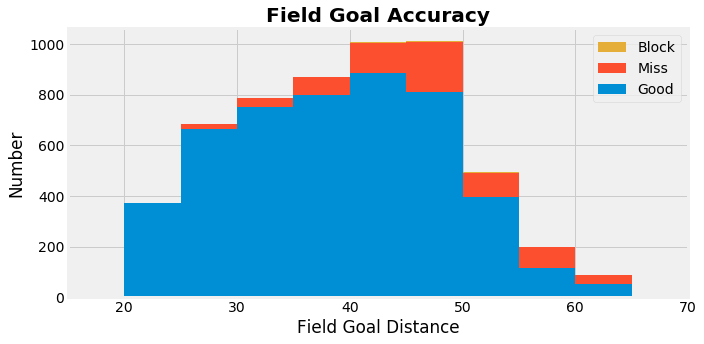

In [211]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Number')
plt.bar(fgRange,blockListn,bottom=[goodListn[i]+missListn[i] for i in range(len(goodListn))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missListn,bottom=goodListn,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodListn,width=5,label='Good',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
plt.xlim(15,70)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/fgResults_total.png')
plt.show()

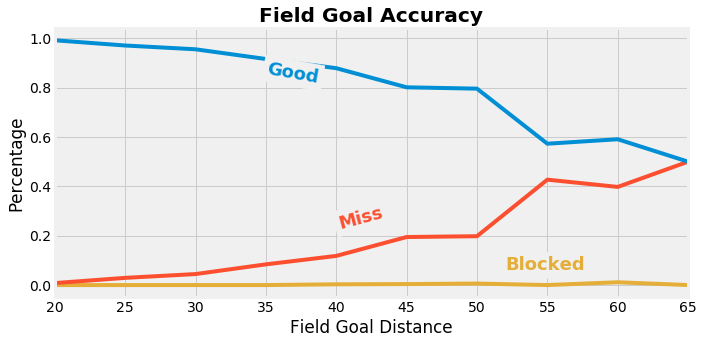

In [212]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Percentage')
plt.plot(fgRange,blockList,label='Block',c='C2')
plt.plot(fgRange,missList,label='Miss',c='C1')
plt.plot(fgRange,goodList,label='Good',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(20,65)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.23, s = 'Miss', color = 'C1', weight = 'bold', size = 18, rotation = 15, backgroundcolor = '#f0f0f0')
plt.text(x = 52, y = 0.06, s = 'Blocked', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 35, y = 0.82, s = 'Good', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/fgResults_line.png')
plt.show()

In [213]:
FGDF.sort_values('FGdist',ascending=False).head(10)

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
83156,162,1,3,4:41,1181,4.0,14.0,SJS,48.0,"65 yard FG by Turkleton, T. is NO good.",1597,6,BAL,SJS,BAL,48.0,21,20,65,Miss
77747,177,1,4,11:27,687,4.0,16.0,OCO,48.0,"65 yard FG by Turkleton, T. is good.",1572,6,OCO,BAL,BAL,48.0,23,27,65,Good
68659,196,1,4,5:56,356,4.0,10.0,AZ,47.0,"64 yard FG by Turkleton, T. is NO good.",1401,5,AZ,BAL,BAL,47.0,34,27,64,Miss
56496,138,1,4,10:42,642,4.0,2.0,ARI,44.0,"61 yard FG by Turkleton, T. is good.",770,4,ARI,BAL,BAL,44.0,13,12,61,Good
58079,31,1,1,7:45,3165,4.0,2.0,PHI,42.0,"59 yard FG by Turkleton, T. is good.",778,4,BAL,PHI,BAL,42.0,7,10,59,Good
224217,71,7,2,12:08,2528,4.0,5.0,OCO,40.0,"57 yard FG by Fulture, K. is good.",3352,15,OCO,PHI,PHI,40.0,10,17,57,Good
259137,78,10,2,3:37,2017,4.0,10.0,AZ,40.0,"57 yard FG by Crisco, A. is NO good.",4211,17,AUS,AZ,AUS,40.0,3,10,57,Miss
53708,101,8,2,0:27,1827,1.0,10.0,ARI,40.0,"57 yard FG by Gooney, W. is good.",757,4,LV,ARI,LV,40.0,7,13,57,Good
297783,107,2,2,0:27,1827,3.0,2.0,COL,40.0,"57 yard FG by Donaldson, N. is NO good.",4731,19,YKW,COL,YKW,40.0,13,7,57,Miss
206728,159,6,4,11:22,682,4.0,4.0,COL,40.0,"57 yard FG by Donaldson, N. is NO good.",3192,14,SJS,COL,SJS,40.0,7,20,57,Miss


In [214]:
FGDF[FGDF['FGresult'] == 'Block']

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
17266,147,7,3,0:22,922,4.0,5.0,BAL,22.0,"39 yard FG by Harris, S. is BLOCKED by Nasher,...",84,2,PHI,BAL,PHI,22.0,27,14,39,Block
46340,179,4,4,7:18,438,4.0,6.0,OCO,24.0,"41 yard FG by Ronaldo, C. is BLOCKED by Verns,...",723,4,ARI,OCO,ARI,24.0,10,20,41,Block
49579,102,6,2,0:08,1808,3.0,23.0,BAL,39.0,"56 yard FG by Blewitt, I. is BLOCKED by Valent...",738,4,SJS,BAL,SJS,39.0,7,7,56,Block
66151,57,8,2,12:03,2523,4.0,2.0,COL,29.0,"46 yard FG by Kicksit, B. is BLOCKED by Saint,...",1390,5,LV,COL,LV,29.0,13,0,46,Block
79996,25,7,1,6:50,3110,4.0,15.0,BAL,22.0,"39 yard FG by Harris, S. is BLOCKED by Dam, D..",1583,6,BAL,PHI,PHI,22.0,0,0,39,Block
205361,97,3,2,0:26,1826,1.0,10.0,PHI,30.0,"47 yard FG by Corbett, K. is BLOCKED by Felix,...",3112,13,COL,PHI,COL,30.0,7,31,47,Block
211258,47,8,1,1:25,2785,4.0,5.0,PHI,25.0,"42 yard FG by Meoff, B. is BLOCKED by (R) Fort...",3214,14,PHI,NO,NO,25.0,7,14,42,Block
255939,104,9,2,0:16,1816,4.0,4.0,BAL,29.0,"46 yard FG by Fulture, K. is BLOCKED by Hobbs,...",3934,16,CHI,BAL,CHI,29.0,7,9,46,Block
280347,145,9,4,14:30,870,4.0,13.0,COL,28.0,"45 yard FG by Fulture, K. is BLOCKED by Berry,...",4554,18,COL,CHI,CHI,28.0,24,14,45,Block
290611,84,1,2,0:11,1811,1.0,10.0,SJS,23.0,"40 yard FG by Brand, F. is BLOCKED by Riposte,...",4604,18,SJS,BAL,BAL,23.0,10,14,40,Block


## Drive Endings

In [215]:
todDF = allData[(allData['play'].str.contains('Turnover'))]

In [216]:
tdDF = allData[(allData['play'].str.contains('TOUCHDOWN'))]

In [217]:
safetyDF = allData[(allData['play'].str.contains('SAFETY'))]

In [218]:
intDF = allData[(allData['play'].str.contains('INTERCEPTION'))]

In [219]:
fumbleDF = allData[(allData['play'].str.contains('FUMBLE'))]

In [220]:
pies = [len(puntDF),len(FGDF),len(todDF),len(tdDF),len(intDF),len(fumbleDF),len(safetyDF)]

In [221]:
labels = ['Punts (%.2f%%)'%(len(puntDF)/sum(pies)*100),
          'FG Att (%.2f%%)'%(len(FGDF)/sum(pies)*100),
          'Turnover (%.2f%%)'%(len(todDF)/sum(pies)*100),
          'Touchdown (%.2f%%)'%(len(tdDF)/sum(pies)*100),
          'Interception (%.2f%%)'%(len(intDF)/sum(pies)*100),
          'Fumble (%.2f%%)'%(len(fumbleDF)/sum(pies)*100),
          'Safety (%.2f%%)'%(len(safetyDF)/sum(pies)*100)]

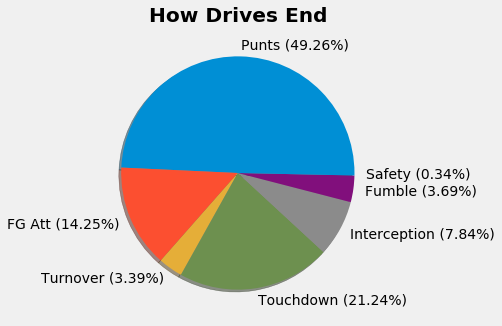

In [222]:
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.title('How Drives End',weight='bold')
plt.pie(pies,labels=labels,shadow=True)
plt.savefig('images/piechart.png')
plt.show()

## Tries

In [223]:
triesDF = fourthTryDF[(fourthTryDF['playType'] == 'Try')]

In [224]:
pd.set_option('display.max_columns', None)  

In [225]:
turnoverList = triesDF.index[triesDF['play'].str.contains('Turnover')].tolist()

In [226]:
intlist = triesDF.index[triesDF['play'].str.contains('INTERCEPTION')].tolist()

In [227]:
fumblelist = triesDF.index[triesDF['play'].str.contains('FUMBLE')].tolist()

In [228]:
turnoverList = [t-1 for t in turnoverList]
turnoverList = turnoverList + intlist + fumblelist

In [229]:
triesDF['tryResult'] = 'Good'

In [230]:
triesDF['tryResult'].loc[turnoverList] = 'Fail'

/home/mike/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [231]:
triesDF = triesDF[~triesDF['play'].str.contains('Turnover')]

In [232]:
triesDF['tryResult'].value_counts(normalize=True)

Fail    0.570591
Good    0.429409
Name: tryResult, dtype: float64

In [233]:
triesDistArr = []
triesDistArrn = []
triesRange = np.arange(1,40,1)
for i in triesRange:
    i4df = triesDF[triesDF['distance'] == i]
    triesDistArr.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn.append(i4df['tryResult'].value_counts(normalize=False))

In [234]:
triesgoodList = []
triesmissList = []
for f in triesDistArr:
    try:
        triesgoodList.append(f['Good'])
    except KeyError:
        triesgoodList.append(0.)
    try:
        triesmissList.append(f['Fail'])
    except KeyError:
        triesmissList.append(0.)

In [235]:
triesgoodListn = []
triesmissListn = []
for f in triesDistArrn:
    try:
        triesgoodListn.append(f['Good'])
    except KeyError:
        triesgoodListn.append(0.)
    try:
        triesmissListn.append(f['Fail'])
    except KeyError:
        triesmissListn.append(0.)

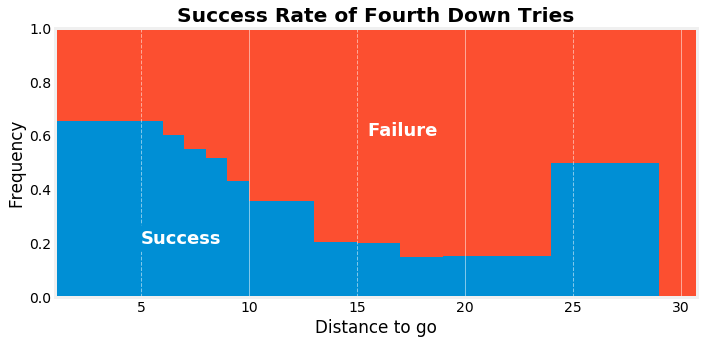

In [236]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.bar(triesRange,triesmissList,bottom=triesgoodList,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodList,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,30.75)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 15.5, y = 0.6, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults.png')
plt.show()

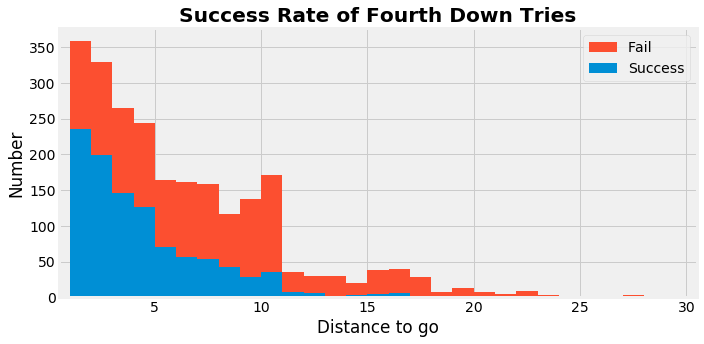

In [237]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Number')
plt.bar(triesRange,triesmissListn,bottom=triesgoodListn,width=1,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodListn,width=1,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_total.png')
plt.show()

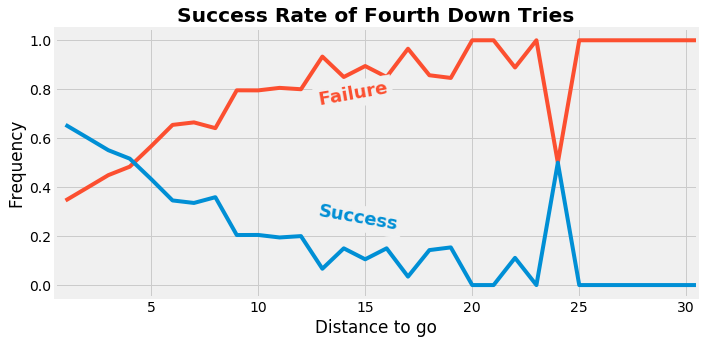

In [238]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.plot(triesRange,triesmissList,label='Fail',color='C1')
plt.plot(triesRange,triesgoodList,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 12.75, y = 0.735, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 12.75, y = 0.225, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_line.png')
plt.show()

In [239]:
triesDistArr2 = []
triesDistArrn2 = []
triesRange2 = np.arange(0,100,5)
for i in triesRange2:
    i4df = triesDF[triesDF['dist2goal'] == i]
    triesDistArr2.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn2.append(i4df['tryResult'].value_counts(normalize=False))

In [240]:
triesgoodList2 = []
triesmissList2 = []
for f in triesDistArr2:
    try:
        triesgoodList2.append(f['Good'])
    except KeyError:
        triesgoodList2.append(0.)
    try:
        triesmissList2.append(f['Fail'])
    except KeyError:
        triesmissList2.append(0.)

In [241]:
triesgoodListn2 = []
triesmissListn2 = []
for f in triesDistArrn2:
    try:
        triesgoodListn2.append(f['Good'])
    except KeyError:
        triesgoodListn2.append(0.)
    try:
        triesmissListn2.append(f['Fail'])
    except KeyError:
        triesmissListn2.append(0.)

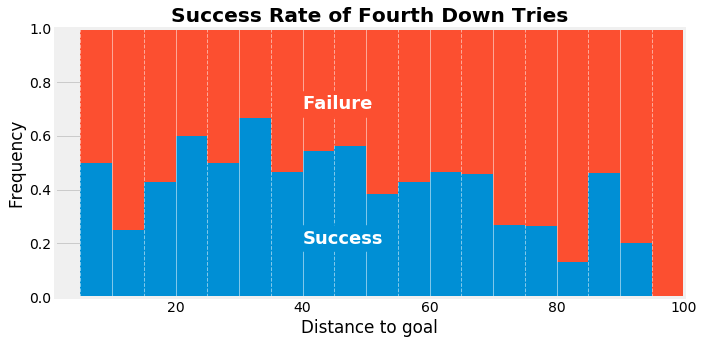

In [242]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.bar(triesRange2,triesmissList2,bottom=triesgoodList2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodList2,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65,75,85,95]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,100)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.7, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults_field.png')
plt.show()

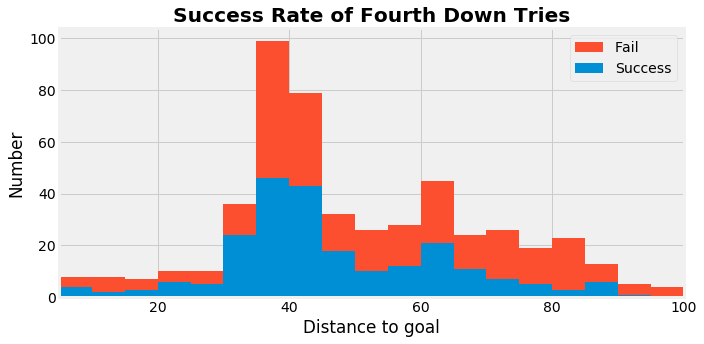

In [243]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Number')
plt.bar(triesRange2,triesmissListn2,bottom=triesgoodListn2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodListn2,width=5,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(5,100)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_field_total.png')
plt.show()

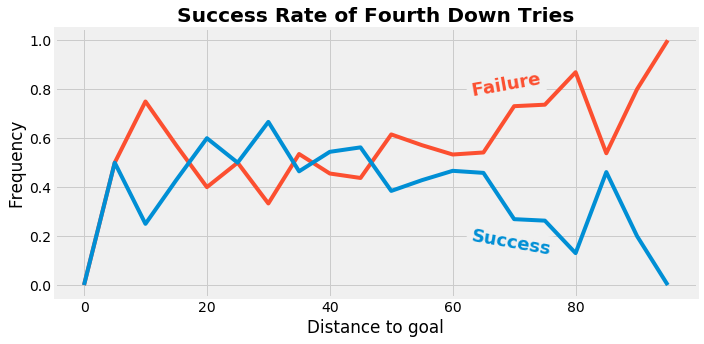

In [244]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.plot(triesRange2,triesmissList2,label='Fail',color='C1')
plt.plot(triesRange2,triesgoodList2,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
# plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 62.75, y = 0.775, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 62.75, y = 0.125, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_field_line.png')
plt.show()

In [245]:
pd.set_option('display.max_colwidth', -1)
triesDF[(triesDF['distance']>=15) & (triesDF['tryResult'] == 'Good')].sort_values('distance',ascending=False)

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,recTeam,dist2goal,awayScore,homeScore,playType,scoreDiff,tryResult
209755,192,8,4,1:04,64,4.0,24.0,NO,23.0,"Pass by Maximus III, B., complete to Fyodorovich, V. for 24 yds. Tackle by Hondo, A..",3206,14,BAL,NO,NO,77.0,20,31,Try,11,Good
177744,211,3,4,7:14,434,4.0,22.0,COL,18.0,"Pass by McCormick, M., complete to Wachter, J. for 33 yds. Tackle by Grithead, D..",2878,12,OCO,COL,COL,82.0,24,48,Try,24,Good
57812,207,3,4,5:24,324,4.0,19.0,COL,33.0,"Pass by Pierno, N., complete to Tweed, B. for 22 yds. Tackle by Floggity, J..",776,4,YKW,COL,COL,67.0,0,31,Try,31,Good
256651,195,6,4,7:42,462,4.0,19.0,SJS,24.0,"Pass by Christ, J., complete to Flash, X. for 28 yds. Tackle by Lee, L..",3937,16,AZ,SJS,SJS,76.0,14,41,Try,27,Good
255827,209,10,4,2:08,128,4.0,18.0,PHI,48.0,"Pass by Cole (R), E., complete to Tidwell (R), R. for 43 yds. Tackle by Verden, J..",3933,16,PHI,AUS,AUS,48.0,13,31,Try,18,Good
32281,193,5,4,5:56,356,4.0,17.0,OCO,24.0,"Pass by Boss, M., complete to Wright Jr, G. for 17 yds. Tackle by Kane, M..",285,3,YKW,OCO,OCO,76.0,9,34,Try,25,Good
57180,210,8,4,3:28,208,4.0,16.0,SJS,46.0,"Pass by Stone, W., complete to Tanner, C. for 26 yds. Tackle by Bayley, B..",773,4,LV,SJS,LV,46.0,24,6,Try,18,Good
95447,205,3,4,0:54,54,4.0,16.0,COL,42.0,"Pass by (R) Applehort, R., complete to Wheat, B. for 22 yds. Tackle by Carter, P..",1728,7,COL,YKW,COL,58.0,26,15,Try,11,Good
155381,209,7,4,5:22,322,4.0,16.0,PHI,14.0,"Pass by Noble, L., complete to Weathers III, B. for 20 yds. Tackle by Flock, R..",2569,10,COL,PHI,PHI,86.0,10,34,Try,24,Good
159964,225,3,4,1:28,88,4.0,16.0,YKW,40.0,"Pass by McCormick, M., complete to North, F. for 31 yds. Tackle by Zhang, S..",2664,11,YKW,COL,COL,40.0,27,38,Try,11,Good


## Sacks?

In [246]:
allData = pd.read_csv('all_post19.csv')

In [247]:
jolietSacks = allData[(allData.play.str.contains('SACKED')) & (allData.play.str.contains('Christ (R), J.')) & (allData.S < 4)]
jolietSacks

/home/mike/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore


In [121]:
jolietSacks = allData[(allData.play.str.contains('SACKED')) & (allData.play.str.contains('Jarden, G.')) & (allData.S < 4)]

In [122]:
jolietSacks

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore


In [123]:
jolietSackList = [int(jolietSacks.iloc[b].play.split('for ')[1].split(' yds.')[0]) for b in range(len(jolietSacks))]

In [124]:
sum(jolietSackList)

0

In [125]:
def getSackYards(player):
    sacksDF = allData[(allData.play.str.contains('SACKED')) & (allData.play.str.contains(player))]
    sackList = [int(sacksDF.iloc[b].play.split('for ')[1].split(' yds.')[0]) for b in range(len(sacksDF))]
    return -sum(sackList)

In [126]:
getSackYards('Blocksdale, A.')

2340

In [127]:
QBs = ['Boss, M.','Maximus III, B.','Blocksdale, A.','Showbiz, G.','Falconi, A.','Bronko, K.','Applehort, R.','Akselsen, M.','Orosz, C.','Christ, Joliet','Reese, A.','McCormick, M.','Bigsby, C.','Gambino, C.','Fitzpatrick, K.','Havran, C.','Oles, T.','Pennington, B.','Jenkins, R.','Cole, E.','Francisco, S.','Rove, C.','McDummy, W.','Noble, L.','Armstrong, F.','Kyubee, S.','Pierno, N.','Hunt, E.','Bercovici, J.','Christ, Jameis','Wright, D.','Draxel, V.','Adams, C.','Strike, M.']

In [128]:
for qb in QBs:
    print('%i'%(getSackYards(qb)))

4838
4137
2340
3114
2547
3637
3313
2127
3176
0
2307
1332
1683
1249
1427
766
1368
1636
1028
991
1216
2193
914
3081
522
1482
1512
1043
1396
0
612
800
18
73
